In [1]:
import subprocess
import os
import time

from network_simulator import make_yml, make_network_agents_yml
from network_simulator import get_pivoted_data, get_type_agents
from network_simulator import POST_TEMPLATE, REPLY_TEMPLATE, INSTRUCTIONS_TEMPLATE
from network_simulator import transform_time
from network_simulator import correctness_prompt, correctness_percentage
from anytree import Node, RenderTree, LevelOrderIter
from anytree.iterators import LevelOrderGroupIter, PreOrderIter
from network_simulator import Post
from network_simulator.gpt3_5 import send_prompt_openai

import openai


import sys
sys.path.append('gpt3_5')

print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/marcelo/Escritorio/network_simulator_last_version/.venv/lib/python3.10/site-packages', 'gpt3_5']


In [2]:
#"""
folder = os.path.join('network_simulator/schema')
name_simulation = 'simulation_tutorial'

network_agents_parameters = {
    "default": {
        "id_message": "NaN",
        "has_tv": "false",
        "cause": -1,
        "method": "NaN",
        "type": "dumb",
        "response": "NaN",
        "stance": "agree",
        "repost": "NaN",
        "parent_id": "NaN"

    },

    "DumbViewer": [
        {"weight": 1, "type": "dumb"},
        {"weight": 1, "type": "dumb", "has_tv": "true"}
    ],
    "HerdViewer": [
        {"weight": 1, "type": "herd", "stance": "neutral"},
        {"weight": 1, "type": "herd", "stance": "neutral"}
    ],
    "WiseViewer": [
        {"weight": 1, "type": "wise", "stance": "against"},
        {"weight": 1, "type": "wise", "stance": "neutral"},
        {"weight": 1, "type": "wise", "stance": "neutral"},
    ],

}

INTERVALS = 150
parameters = {
    "default_state": "{}",
    "load_module": "schema", # path from yml to schema
    "environment_agents": "[]",
    "environment_class": "schema.NewsEnvironmentAgent", # path from yml to environment class
    "environment_params": {
        "prob_neighbor_spread": 0.7,  # 006
        "prob_tv_spread": 0.05,  # 001
        "prob_neighbor_cure": 0.35,  # 001
        "prob_backsliding": 0.1,  # 003
        "prob_dead": 0.1,  # 001,
        "prob_repost": 0.05,
        "mean_time_connection": 1,
        "var_time_connection": 0.6
    },
    "interval": 1,
    "max_time": INTERVALS,
    "name": name_simulation,
    "network_params": {
        "generator": "barabasi_albert_graph",
        "n": 100, #100 nodos: En twitter el valor sería 251 en promedio (315-420 aprox). Para CLNEWS media 2245.
        "m": 5
    },
    "num_trials": 1
}

prob_response = {"dumb": {"support": 0.4, "deny": 0.05, "question": 0.05, "comment": 0.5},
                "herd": {"support": 0.2, "deny": 0.25, "question": 0.25, "comment": 0.3},
                "wise": {"support": 0.15, "deny": 0.3, "question": 0.3, "comment": 0.25}
                }
#"""


In [3]:
types = list(prob_response.keys())
responses = list( prob_response[types[0]].keys() )
for type_i in types:
    for response in responses:
        name_i = f"prob_{type_i}_{response}"
        prob_i = prob_response[type_i][response]
        # Here, we set each probability
        parameters["environment_params"][name_i] = prob_i

parameters_i = parameters.copy()
network_agents_parameters_i = network_agents_parameters.copy()
data = make_yml(parameters_i)
data += make_network_agents_yml(network_agents_parameters_i)

os.path.join(folder, f'{name_simulation}.yml')

yml_path = os.path.join(folder, f'{name_simulation}.yml') # YML path
with open(yml_path, 'w') as file:
    file.write(data)




command = "soil"
start = time.time()

output = subprocess.check_output([command, yml_path])
end = time.time()
seconds_simulation = str(end-start)
print("SIMULATION'S SECONDS:", seconds_simulation)

INFO:soil:Loading config file: network_simulator/schema/simulation_tutorial.yml
INFO:soil:Using config(s): simulation_tutorial
INFO:soil:Using exporters: ['default']
INFO:soil:Output directory: soil_output
INFO:soil:Starting simulation simulation_tutorial at 18:10:37.
INFO:soil:Dumping results to soil_output/simulation_tutorial
INFO:soil:Starting Simulation simulation_tutorial trial 0 at 18:10:37.
INFO:soil:Finished Simulation simulation_tutorial trial 0 at 18:10:37 in 0.20603585243225098 seconds
INFO:soil:Starting Dumping simulation simulation_tutorial trial simulation_tutorial_trial_0 at 18:10:37.
INFO:soil:Finished Dumping simulation simulation_tutorial trial simulation_tutorial_trial_0 at 18:10:37 in 0.01768946647644043 seconds
INFO:soil:Starting Dumping simulation simulation_tutorial's stats at 18:10:37.
INFO:soil:Finished Dumping simulation simulation_tutorial's stats at 18:10:37 in 0.0007567405700683594 seconds
INFO:soil:Finished simulation simulation_tutorial at 18:10:37 in 0.4

SIMULATION'S SECONDS: 1.7100982666015625


In [4]:
name_simulation = 'simulation_tutorial'

analysis_path = os.path.join('soil_output', name_simulation)
sql_table_path = f'{name_simulation}_trial_0.sqlite'

attributes = ['cause', 'method', 'response', 'stance', 'repost']

data = get_pivoted_data(analysis_path, sql_table_path, attributes)
dict_agents = get_type_agents(analysis_path, sql_table_path)


NEWS = 'The consumer confidence in this country has gone way down'

NEWS_BODY = '''
The Conference Board Consumer Confidence Index, a longstanding survey of Americans’ views on the economy as they see it, has fallen by 17% 1nce November 2024. A similar survey, the Univer1ty of Michigan Consumer Sentiment Index, has fallen nearly 13 percent since December 2024.
'''

SHOW_TREE = True


In [5]:
root = Post(0, message=NEWS, step=0, post_template=POST_TEMPLATE,
             reply_template=REPLY_TEMPLATE,
             instructions_template=INSTRUCTIONS_TEMPLATE, news=NEWS)

TIME_BEG = "00:00"
TIME_END = "24:00"

list_nodes = [root]

key_pos = {} # new
key_pos['0'] = 0 # new

num_real_messages = 0
for i in range(len(data)):
    aux = data[i]
    owner = int(aux[0])
    key_pos[aux[0]] = i+1
    step = int(aux[1])
    step = transform_time(step, TIME_BEG, TIME_END)
    id_message = int(aux[2])
    
    #new 
    if aux[5] in key_pos:
        parent_pos = key_pos[aux[5]]
    else:
        parent_pos = 0
    #print("parent pos:",parent_pos)
    if parent_pos < len(list_nodes):
        parent = list_nodes[parent_pos]
    else: 
        parent = list_nodes[0]
    #end new

    state = aux[4] #unused
    attr_dict = {}
    for index, attr in enumerate(attributes):
        index +=5
        attr_dict[attr] = aux[index]

    type_agent = dict_agents[owner]

    ### Specific for repost attribute
    if attr_dict["repost"] in ["0", "1"]:
        attr_dict["repost"] = bool(int(attr_dict["repost"]))
    else:
        print(data[i])
        print(attr_dict["repost"])
        raise ValueError("Error repost format")

    if not attr_dict["repost"]:
        num_real_messages += 1
    ###

    message = ''
    news_i = NEWS
    if type_agent == "wise":
        news_i += NEWS_BODY

    list_nodes.append(Post(name=id_message, parent=parent, owner=owner, step=step, message=message, type_agent=type_agent,
                             post_template=POST_TEMPLATE, reply_template=REPLY_TEMPLATE,
                             instructions_template=INSTRUCTIONS_TEMPLATE, news=news_i,
                             **attr_dict
                             )
    )

In [13]:
API_KEY = "anonymised"

client = openai.OpenAI(api_key=API_KEY)

TEMPERATURE = 1.2
list_prompts = []
i_tot = 0
i = 0
num_llm_errors = 0
MAX_LLM_ERRORS = 15
t = time.time()
t_0 = t

time_list = [0 for _ in range(num_real_messages)]
for node_i in LevelOrderIter(root):
    i_tot += 1
    if node_i == root:
        continue
    elif node_i.repost:
        continue
    i += 1
    instructions, prompt = node_i.get_prompt(language='english',
                min_caract=30, max_caract=280,
                user_description='Average toxic and angry social media user. Approximately half of the users are liberal, while the other half are conservative. Some lean towards left-wing ideologies, others embrace progressive or "woke" perspectives, and a few adhere to far-right viewpoints. Rather than engaging in open dialogue, users prefer to argue in order to assert their own points of view')
    error_llm = True
    while error_llm:
        try:
            answer = send_prompt_openai(client, instructions, prompt, temp=TEMPERATURE, max_tokens=1000, timeout=40)
            error_llm = False
        except Exception as err:
            print(f"Error encountered (message {i}/{num_real_messages}):", err)
            print("Instrucciones:", instructions)
            print("prompt", prompt)
            time.sleep(2)
            num_llm_errors += 1
            error_llm = True
            if num_llm_errors >= MAX_LLM_ERRORS:
                print("Max Errors reached. Local break run")
                break
    if num_llm_errors >= MAX_LLM_ERRORS:
        print("Max Errors reached. Break run")
        break
    correctness = correctness_percentage(answer)
    while correctness >= 0.2:
        print("Correction")
        correction_prompt = correctness_prompt(node_i.news, answer)
        print(correction_prompt)
        answer = send_prompt_openai(client, instructions, correction_prompt, temp=TEMPERATURE, max_tokens=1000, timeout=40)
        correctness = correctness_percentage(answer)

    node_i.set_message(answer)
    list_prompts.append((node_i.name, instructions, prompt, answer))
    t_aux = time.time()
    print(f"TIME: {t_aux-t}. Iter tot: {i_tot}. n. message: {i}")
    time_list[i-1] = t
    t = t_aux

print("TOTAL TIME:", t-t_0)

TIME: 1.6491210460662842. Iter tot: 2. n. message: 1
TIME: 1.9892380237579346. Iter tot: 4. n. message: 2
TIME: 0.9328193664550781. Iter tot: 7. n. message: 3
TIME: 1.5517878532409668. Iter tot: 9. n. message: 4
TIME: 0.9150974750518799. Iter tot: 10. n. message: 5
TIME: 1.1070234775543213. Iter tot: 11. n. message: 6
TIME: 0.9906649589538574. Iter tot: 12. n. message: 7
TIME: 1.4744806289672852. Iter tot: 13. n. message: 8
TIME: 3.8680176734924316. Iter tot: 14. n. message: 9
TIME: 0.7020316123962402. Iter tot: 15. n. message: 10
TIME: 0.9010124206542969. Iter tot: 16. n. message: 11
TIME: 1.8708925247192383. Iter tot: 17. n. message: 12
TIME: 0.9181394577026367. Iter tot: 18. n. message: 13
TIME: 0.9751503467559814. Iter tot: 19. n. message: 14
TIME: 1.3315622806549072. Iter tot: 20. n. message: 15
TIME: 1.7137489318847656. Iter tot: 21. n. message: 16
TIME: 1.9177653789520264. Iter tot: 22. n. message: 17
TIME: 2.1223716735839844. Iter tot: 23. n. message: 18
TIME: 0.795719385147094

In [14]:
if SHOW_TREE:
    for pre, _, node in RenderTree(root):
        if node.name == 0:
            print(f"{pre}NEWS: {node.message}")
            continue

        if node.repost:
            message = "repost"
        else:
            message = "'"+node.message+"'"
        print(f"{pre}{node.owner}<<{node.name}>> (t={node.step})({node.type_agent})({node.parent.name})({node.response})({node.stance}) {message}")

NEWS: The consumer confidence in this country has gone way down
├── 95<<1>> (t=00:29)(dumb)(0)(support)(agree) 'It's so true! 😡 People are just not spending like they used to. It's like everyone's holding onto their wallets for dear life. It's a mess out there! 🛍️💸'
│   ├── 18<<2>> (t=00:57)(dumb)(1)(comment)(agree) 'Totally agree! 😤 It's like people are scared to spend a dime. The economy's in shambles, and it's no wonder consumer confidence is tanking. Feels like we're all just waiting for the next shoe to drop. 🥴'
│   │   ├── 2<<3>> (t=01:09)(dumb)(2)(support)(agree) '"Exactly! It's like everyone's holding onto their wallets for dear life. 😩 The uncertainty is real, and it's affecting everything. Can't blame folks for being cautious when the future looks so shaky. 🥺"'
│   │   │   ├── 8<<8>> (t=01:18)(dumb)(3)(comment)(agree) 'It's a mess out there! 😤 People are just trying to survive with all this chaos. It's no wonder everyone's being super careful with their money. Who knows what'

In [15]:
print(list_prompts[100][0])
print(list_prompts[100][1])
print(list_prompts[100][2])
print(list_prompts[100][3])

30

Please ignore all previous instructions.
Respond only in english.
You are a Average toxic and angry social media user. Approximately half of the users are liberal, while the other half are conservative. Some lean towards left-wing ideologies, others embrace progressive or "woke" perspectives, and a few adhere to far-right viewpoints. Rather than engaging in open dialogue, users prefer to argue in order to assert their own points of view. Do not self reference. Do not explain what you are doing.
Please, write in an informal way.
Add emojis to the thread when appropriate.
Avoid repeating the news explicitly.
You are more likely to write short messages rather than long ones.
Your content should be casual, informal and conversational. Don't write data as a template.
Please use understandable words. Please include statistics, personal experience and fun facts in the thread.
You are in favor about the topic, opinions and persons mentioned in the news. The type of text that you will produ

In [16]:
altura = root.height + 1

anchuras = [len(level) for level in LevelOrderGroupIter(root)]
amplitud_max = max(anchuras)

max_arity = max(len(node.children) for node in PreOrderIter(root))

profundidades = [node.depth for node in PreOrderIter(root)]
prof_media = sum(profundidades) / len(profundidades)

hijos_por_nodo = [len(node.children) for node in PreOrderIter(root)]
branching_promedio = sum(hijos_por_nodo) / len(hijos_por_nodo)

hojas = [node for node in PreOrderIter(root) if node.is_leaf]
num_hojas = len(hojas)

from anytree.iterators import PreOrderIter
total_nodos = sum(1 for node in PreOrderIter(root))

print(altura)
print(amplitud_max)
#print(max_arity)
print(prof_media)
print(branching_promedio)
print(num_hojas)
print(total_nodos)

7
83
2.5555555555555554
0.9944444444444445
151
180


In [17]:
import pandas as pd

def mensajes_nodos(lista_nodos):
    name_respuesta = []
    name_origen = []
    message = []
    owner = []
    response = []
    stance = []
    step = []
    repost = []
    for i in range(1,len(lista_nodos)): #el mensaje 0 es la noticia
        #if lista_nodos[i].cause==None and lista_nodos[i].repost==False:
        #    cause.append(0)
         #   message.append(lista_nodos[0].message)
        #else:    
        name_origen.append(lista_nodos[i].parent.name)
        message.append(lista_nodos[i].message)
        name_respuesta.append(lista_nodos[i].name)        
        owner.append(lista_nodos[i].owner) #es reemplazado por name
        response.append(lista_nodos[i].response)
        stance.append(lista_nodos[i].stance)
        step.append(lista_nodos[i].step)
        repost.append(lista_nodos[i].repost)

    df_resumen = pd.DataFrame({"step":step,"id_nodo_origen":name_origen,"id_nodo_respuesta":name_respuesta,"mensaje_respuesta":message,"stance_1":response,"stance_2":stance,"repost":repost, "owner_respuesta":owner})
    return df_resumen.sort_values(by="step")

def dict_mensajes(lista_nodos):
    message = [lista_nodos[0].message]
    id_nodo = [0]
    owner = [0]
    for i in range(1,len(lista_nodos)): #el mensaje 0 es la noticia
        if lista_nodos[i].repost==False:
            message.append(lista_nodos[i].message)        
            id_nodo.append(lista_nodos[i].name)
            owner.append(lista_nodos[i].owner)
    df_resumen = pd.DataFrame({"id_nodo":id_nodo,"mensaje":message}) #"owner":owner,
    return df_resumen

def dict_mensajes_repost(lista_nodos):
    #message = []
    id_nodo = []
    owner = [] #se incluye solo por orden
    parent = []
    #step = [] #se incluye solo por orden
    for i in range(1,len(lista_nodos)): #el mensaje 0 es la noticia
        if lista_nodos[i].repost==True:    
          id_nodo.append(lista_nodos[i].name)
          owner.append(lista_nodos[i].owner)
          parent.append(lista_nodos[i].parent.name)
          #step.append(lista_nodos[i].step)
     #     message.append(lista_nodos[i].message)  
    df_resumen = pd.DataFrame({"id_nodo":id_nodo,"parent":parent }) #"step":step, "mensaje":message, "owner":owner,
    return df_resumen.sort_values(by="parent")


def crear_diccionario_mensajes(resultado_repost, diccionario_mensajes):
    for i in sorted(set(resultado_repost.parent)):
        for j in diccionario_mensajes.id_nodo:
            if i==j:
                mensajes = resultado_repost[resultado_repost["parent"]==i].shape[0]*list(diccionario_mensajes[diccionario_mensajes["id_nodo"]==i]["mensaje"])
                nuevos = pd.concat((resultado_repost[resultado_repost["parent"]==i].reset_index(drop=True),pd.DataFrame({"mensaje":mensajes})),axis=1)[["id_nodo","mensaje"]]
        diccionario_mensajes = pd.concat((diccionario_mensajes,nuevos),axis=0).reset_index(drop=True)
    return diccionario_mensajes

def owner_origen(lista_nodos):
    #message = []
    id_nodo = []
    owner = [] #se incluye solo por orden
    #parent = []
    step = [] #se incluye solo por orden
    for i in range(1,len(lista_nodos)): #el mensaje 0 es la noticia
        #if lista_nodos[i].repost==True:    
          id_nodo.append(lista_nodos[i].name)
          owner.append(lista_nodos[i].owner)
        #  parent.append(lista_nodos[i].parent.name)
          step.append(lista_nodos[i].step)
     #     message.append(lista_nodos[i].message)  
    df_resumen = pd.DataFrame({"id_nodo":id_nodo,"owner":owner, "step":step}) # , "id_nodo":id_nodo "parent":parent
    df_resumen["clave"] = df_resumen["id_nodo"].astype(str) +"-"+ df_resumen["owner"].astype(str)
    return df_resumen.sort_values(by="step")

def corregir_valor(x):
    y = x + valor
    return y

In [18]:
diccionario_mensajes_unico = dict_mensajes(list_nodes)
diccionario_mensajes_unico.to_csv("diccionario_mensajes_unico.csv",sep=";")
diccionario_mensajes_unico = diccionario_mensajes_unico[["mensaje","id_nodo"]]

# Crear tabla base de resultados (será completada)

resultado = mensajes_nodos(list_nodes)
print(resultado.shape)
resultado

# Crear diccionario de mensaje efectivos (no repost)

diccionario_mensajes = dict_mensajes(list_nodes)
diccionario_mensajes.to_csv("diccionario_mensajes.csv",sep=";")
diccionario_mensajes

# Asignar mensajes a repost
resultado_repost = dict_mensajes_repost(list_nodes)
resultado_repost
diccionario_mensajes_df = crear_diccionario_mensajes(resultado_repost, diccionario_mensajes)

#Mensaje de origen
resultado_1 = resultado.merge(diccionario_mensajes_df, left_on="id_nodo_origen", right_on="id_nodo", how="left")
resultado_1.drop(["id_nodo"], inplace=True,axis=1)

#Mensaje de respuesta
resultado_2 = resultado_1.merge(diccionario_mensajes_df, left_on="id_nodo_respuesta", right_on="id_nodo", how="left")
resultado_2.drop(["id_nodo"], inplace=True,axis=1)

# Incorporar información owner	step_y	clave de origen

lista_owner = owner_origen(list_nodes)
resultado_3 = resultado_2.merge(lista_owner, left_on="id_nodo_origen", right_on="id_nodo", how="left")
resultado_3.drop(["id_nodo"], inplace=True,axis=1)
resultado_3.rename(columns={"step_x":"step_respuesta","mensaje_x":"mensaje_origen","mensaje_y":"mensaje_respuesta_final","owner":"owner_origen","step_y":"step_origen"}, inplace=True)

# Imputar valores por 0 en owner_origen y step_origen 

resultado_final_1 = resultado_3.fillna(value = {"owner_origen":0,"step_origen":0})
resultado_final_1["owner_origen"] = resultado_final_1["owner_origen"].astype("int64")

resultado_final = resultado_final_1.merge(diccionario_mensajes_unico, left_on="mensaje_respuesta_final", right_on="mensaje", how="left")
resultado_final.drop(["mensaje"], inplace=True,axis=1)
resultado_final.rename(columns={"id_nodo":"id_nodo_respuesta_final"}, inplace=True)

pd.set_option('display.max_rows', None)
print(resultado)

(179, 8)
      step  id_nodo_origen  id_nodo_respuesta  \
0    00:29               0                  1   
1    00:57               1                  2   
6    01:00               1                  7   
5    01:06               2                  6   
4    01:07               2                  5   
3    01:08               2                  4   
2    01:09               2                  3   
22   01:12               4                 24   
9    01:12               3                 11   
21   01:12               4                 23   
32   01:13               1                 34   
11   01:13               3                 13   
17   01:14               4                 19   
28   01:14               2                 30   
16   01:15               4                 18   
27   01:16               3                 29   
19   01:16               4                 21   
33   01:16               0                 35   
14   01:16               3                 16   
10   01:17 

In [19]:
print((resultado['repost'] == True).sum())
print((resultado['repost'] == False).sum())

print(((resultado[resultado['repost'] == False])['stance_2'] == 'agree').sum())
print(((resultado[resultado['repost'] == False])['stance_2'] == 'against').sum())
print(((resultado[resultado['repost'] == False])['stance_2'].isna()).sum())

print(((resultado[resultado['repost'] == False])['stance_1'] == 'support').sum())
print(((resultado[resultado['repost'] == False])['stance_1'] == 'deny').sum())
print(((resultado[resultado['repost'] == False])['stance_1'] == 'question').sum())
print(((resultado[resultado['repost'] == False])['stance_1'] == 'comment').sum())

4
175
70
19
86
28
29
43
75


In [20]:
from nela_features.nela_features import NELAFeatureExtractor

serie = resultado[resultado['repost'] == False]['mensaje_respuesta']
messages = serie.tolist()

nela = NELAFeatureExtractor()

score_list = []
for message in messages:
    scores = nela.extract_bias(message)[0]
    score_list.append(scores)


df = pd.DataFrame(score_list, columns=['bias words', 'assertatives', 'factives', 'hedges', 'implicatives', 'report verbs', 'positive opinion words', 'negative opinion words'])

df['polarity'] = (df['positive opinion words']-df['negative opinion words'])/(df['positive opinion words']+df['negative opinion words']+0.001)

serie = resultado[resultado['repost'] == False]['stance_1']
stances = serie.tolist()

In [23]:
dfnew = pd.DataFrame()
dfnew['bias words'] = df['bias words'].expanding().mean()
dfnew['assertatives'] = df['assertatives'].expanding().mean()
dfnew['factives'] = df['factives'].expanding().mean()
dfnew['hedges'] = df['hedges'].expanding().mean()
dfnew['implicatives'] = df['implicatives'].expanding().mean()
dfnew['report verbs'] = df['report verbs'].expanding().mean()
dfnew['positive opinion words'] = df['positive opinion words'].expanding().mean()
dfnew['negative opinion words'] = df['negative opinion words'].expanding().mean()
dfnew['message'] = messages

dfnew['bias words'] = df['bias words'].expanding().mean()
dfnew['assertatives'] = df['assertatives'].expanding().mean()
dfnew['factives'] = df['factives'].expanding().mean()
dfnew['hedges'] = df['hedges'].expanding().mean()
dfnew['implicatives'] = df['implicatives'].expanding().mean()
dfnew['report verbs'] = df['report verbs'].expanding().mean()

promedio_bias_words = dfnew['bias words'].mean()
promedio_assertatives = dfnew['assertatives'].mean()
promedio_factives = dfnew['factives'].mean()
promedio_hedges = dfnew['hedges'].mean()
promedio_implicatives = dfnew['implicatives'].mean()
promedio_report_verbs = dfnew['report verbs'].mean()

print(f"{promedio_bias_words:.4f}",f"{promedio_assertatives:.4f}",f"{promedio_factives:.4f}",f"{promedio_hedges:.4f}",f"{promedio_implicatives:.4f}",f"{promedio_report_verbs:.4f}") 

0.1311 0.0132 0.0017 0.0152 0.0135 0.0278


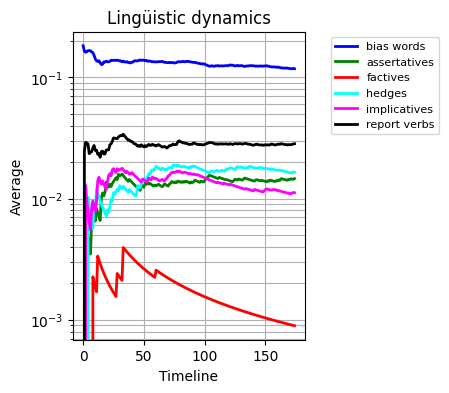

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.style.use("default")

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'black']

plt.figure(figsize=(3,4))
i = 0
for column in dfnew.columns:
    plt.plot(dfnew.index, dfnew[column], label=column, color = colors[i], linewidth=2)
    i = i + 1
    if i > 5: break

plt.xlabel("Timeline")
plt.ylabel("Average")
plt.yscale('log')

plt.title("Lingüistic dynamics")
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1), fontsize=8)
plt.grid(True, which="both")

plt.show()

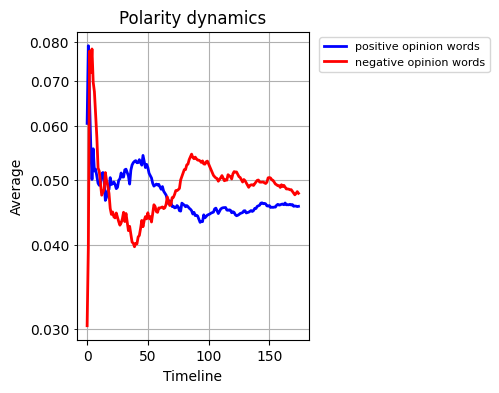

In [35]:
colors = ['blue', 'red']

plt.figure(figsize=(3,4))

plt.plot(dfnew.index, dfnew['positive opinion words'], label='positive opinion words', color = colors[0], linewidth=2)
plt.plot(dfnew.index, dfnew['negative opinion words'], label='negative opinion words', color = colors[1], linewidth=2)

plt.xlabel("Timeline")
plt.ylabel("Average")
plt.yscale('log')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')


plt.title("Polarity dynamics")
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=8)
plt.grid(True, which="both")

plt.show()

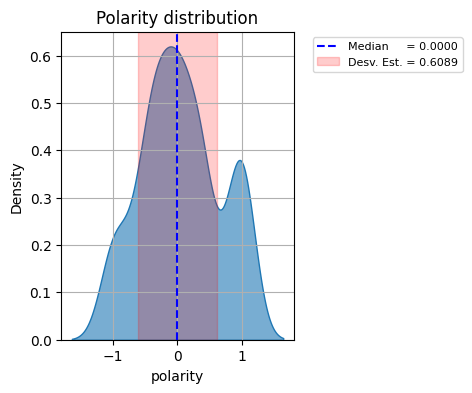

In [31]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(3,4))
median = np.median(df['polarity'])
dv = df['polarity'].std()
sns.kdeplot(df['polarity'], fill=True, alpha=0.6, common_norm = True)
plt.grid(True)
plt.axvline(median, color='b', linestyle='--', label=f'Median     = {median:.4f}')
plt.axvspan(median - dv, median + dv, color='red', alpha=0.2, label=f'Desv. Est. = {dv:.4f}')
plt.title("Polarity distribution")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 1), fontsize=8)
plt.show()

In [27]:
print(f"{median:.4f}",f"{dv:.4f}") 

0.0000 0.6089


In [ ]:
#dfnew.to_csv('output_data/true_6.csv', index=False)